In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import warnings

### a) Predict the journey duration. You may use any Start information in the data set. Also consider creating new features that may help prediction quality (Hint: In the coding week, we discussed creating polynomial features. How would you engineer features for periodic quantities with known period lengths, e.g, a day, a year, …?).

In [2]:
data = pd.read_csv("../data/processed/dortmund_trips.csv", index_col = 0)

In [3]:
data.head()

,datetime_start,b_number_start,latitude_start,p_name_start,longitude_start,datetime_end,latitude_end,p_name_end,longitude_end,trip_duration,distance,weekday,weekend,day,month,hour
0,2019-01-20 16:22:00,50641,51.506312,Hainallee / Südbad,7.470531,2019-01-20 17:00:00,51.493966,TU Dortmund Emil-Figge-Straße 50,7.418008,38,3.897290,6,True,20,1,16
1,2019-01-20 02:31:00,50425,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,2019-01-20 02:43:00,51.513069,Unionstr.,7.448886,12,0.891383,6,True,20,1,2
2,2019-01-20 11:32:00,53006,51.509557,Ritterhausstr.,7.446949,2019-01-20 13:33:00,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,121,1.235649,6,True,20,1,11
3,2019-01-20 14:38:00,53006,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,2019-01-20 14:53:00,51.500725,Polizeipräsidium,7.459819,15,1.827997,6,True,20,1,14
4,2019-01-20 17:02:00,53006,51.500725,Polizeipräsidium,7.459819,2019-01-20 17:16:00,51.514029,Schwanenwall,7.472570,14,1.724677,6,True,20,1,17


Get the outliers in trip duration

Text(0.5, 0, 'trip duration in minutes')

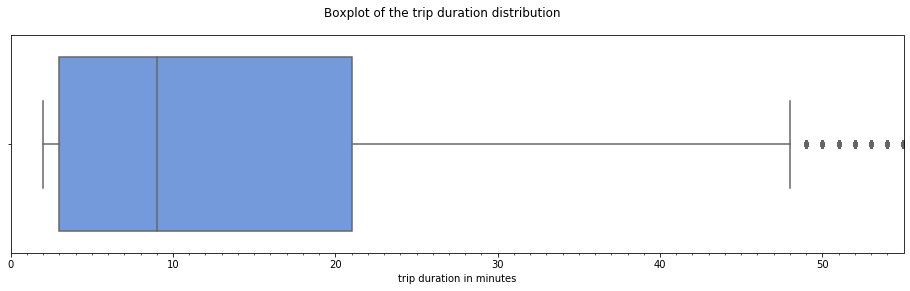

In [4]:
#identifiy outlier record based on trip duration
ax = plt.figure(figsize = (16,4))
ax.suptitle("Boxplot of the trip duration distribution", y=0.98)
ax = sns.boxplot (x=data["trip_duration"], color='cornflowerblue')
ax.set_xticks(np.arange(0, 55),1)
ax.set_xlim([0, 55]) 
ax.set_xlabel('trip duration in minutes')

trips shorter than 2min and longer than 48min are outliers

In [6]:
trips_without_outliers = data[(data["trip_duration"]>= 2) & (data["trip_duration"]<= 48)]

In [7]:
amount_deleted_rows = len(data) - len(trips_without_outliers)
print(amount_deleted_rows, "of", len(data) ,"rows were deleted due outlier-handling")
print("This equals", amount_deleted_rows/len(data) * 100, "%")

27599 of 207476 rows were deleted due outlier-handling
This equals 13.302261466386472 %


In [8]:
# this is our y
duration = data["trip_duration"]

# this is our x
data = data.drop(columns=["trip_duration", "datetime_start", "p_name_start", "b_number_start", "datetime_end", "p_name_end"], axis = 1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, duration, test_size = 0.3)

In [10]:
st_scaler = StandardScaler()
X_train_scaled = st_scaler.fit_transform(X_train)

In [11]:
lin = LinearRegression()
lin.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [12]:
X_test_scaled = st_scaler.transform(X_test)
y_predict = lin.predict(X_test_scaled)

In [13]:
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print("MAE: ", metrics.mean_absolute_error(y_test, y_predict))

RMSE:  80.48557368578165
MAE:  38.6219208253277


In [14]:
from sklearn.decomposition import PCA

In [15]:
pca = PCA(n_components=10)

In [16]:
X_train_transformed =pca.fit_transform(X_train_scaled)

In [17]:
lin = LinearRegression()

In [18]:
lin.fit(X_train_transformed, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
X_test_scaled = st_scaler.transform(X_test)
X_test_transformed = pca.transform(X_test_scaled)
y_predict = lin.predict(X_test_transformed)

In [20]:
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print("MAE: ", metrics.mean_absolute_error(y_test, y_predict))

RMSE:  80.48557368578165
MAE:  38.621920825327685


### b) All cities in your datasets have universities. Based on Start information, predict whether a trip will be towards, or away from the university. Analyze your predictive performance on different subsets of your data (months, …). Do you see differences?

There are multiple university-stations (can be seen in the first map of task 2)
- TU Dortmund Seminarraumgebäude 1
- TU Dortmund Hörsaalgebäude 2
- Universität/S-Bahnhof
- TU Dortmund Emil-Figge-Straße 50
- FH-Dortmund Emil-Figge-Straße 42

There are 2 ways to determine whether a trip is towards/away from the university

1)
check if start/end-station is one of the university-stations
create 2 columns:
- TowardsUniveristy: Yes/No
- AwayFromUniveristy: Yes/No

We need 2 columns (and not solely one) because there is also the case that a trip was done independently from the university


2)
check if the route of a trip is done in direction to the university (or away from the university)
Therefore:

- determine the route/vector of a trips
- chech if this vector is directed in direction to/away from the university

In [21]:
df = pd.read_csv("../data/processed/dortmund_trips.csv", index_col = 0)

In [22]:
university_stations = ["TU Dortmund Seminarraumgebäude 1", "TU Dortmund Hörsaalgebäude 2", "Universität/S-Bahnhof", "TU Dortmund Emil-Figge-Straße 50", "FH-Dortmund Emil-Figge-Straße 42"]

In [23]:
df['towardsUniversity'] = df['p_name_end'].apply(lambda x: 1 if x in university_stations else 0)

In [24]:
df['awayFromUniveristy'] = df['p_name_start'].apply(lambda x: 1 if x in university_stations else 0)

In [25]:
df

,datetime_start,b_number_start,latitude_start,p_name_start,longitude_start,datetime_end,latitude_end,p_name_end,longitude_end,trip_duration,distance,weekday,weekend,day,month,hour,towardsUniversity,awayFromUniveristy
0,2019-01-20 16:22:00,50641,51.506312,Hainallee / Südbad,7.470531,2019-01-20 17:00:00,51.493966,TU Dortmund Emil-Figge-Straße 50,7.418008,38,3.897290,6,True,20,1,16,1,0
1,2019-01-20 02:31:00,50425,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,2019-01-20 02:43:00,51.513069,Unionstr.,7.448886,12,0.891383,6,True,20,1,2,0,0
2,2019-01-20 11:32:00,53006,51.509557,Ritterhausstr.,7.446949,2019-01-20 13:33:00,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,121,1.235649,6,True,20,1,11,0,0
3,2019-01-20 14:38:00,53006,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,2019-01-20 14:53:00,51.500725,Polizeipräsidium,7.459819,15,1.827997,6,True,20,1,14,0,0
4,2019-01-20 17:02:00,53006,51.500725,Polizeipräsidium,7.459819,2019-01-20 17:16:00,51.514029,Schwanenwall,7.472570,14,1.724677,6,True,20,1,17,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207471,2019-12-31 12:39:00,500019,51.500675,Kuithanstr.,7.440834,2019-12-31 12:54:00,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,15,2.262708,1,False,31,12,12,0,0
207472,2019-12-31 19:28:00,500019,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,2019-12-31 19:35:00,51.513069,Unionstr.,7.448886,7,0.891383,1,False,31,12,19,0,0
207473,2019-12-31 12:36:00,51287,51.482359,Barop Parkhaus,7.432326,2019-12-31 15:14:00,51.490505,An der Palmweide,7.438352,158,0.998294,1,False,31,12,12,0,0
207474,2019-12-31 22:37:00,500113,51.510976,Stadtgarten,7.464534,2019-12-31 23:05:00,51.486747,Am Beilstück,7.435750,28,3.355884,1,False,31,12,22,0,0


In [26]:
df[(df["towardsUniversity"] == 1) & (df["awayFromUniveristy"] == 1)]

,datetime_start,b_number_start,latitude_start,p_name_start,longitude_start,datetime_end,latitude_end,p_name_end,longitude_end,trip_duration,distance,weekday,weekend,day,month,hour,towardsUniversity,awayFromUniveristy
10,2019-01-20 11:17:00,53615,51.492690,Universität/S-Bahnhof,7.417633,2019-01-20 15:51:00,51.492690,Universität/S-Bahnhof,7.417633,274,0.000000,6,True,20,1,11,1,1
31,2019-01-20 13:09:00,53473,51.492296,TU Dortmund Hörsaalgebäude 2,7.412730,2019-01-20 13:37:00,51.492690,Universität/S-Bahnhof,7.417633,28,0.343340,6,True,20,1,13,1,1
150,2019-01-21 10:12:00,52331,51.492690,Universität/S-Bahnhof,7.417633,2019-01-21 10:20:00,51.492690,Universität/S-Bahnhof,7.417633,8,0.000000,0,False,21,1,10,1,1
151,2019-01-21 11:24:00,52331,51.492690,Universität/S-Bahnhof,7.417633,2019-01-21 11:29:00,51.491721,TU Dortmund Seminarraumgebäude 1,7.409468,5,0.577203,0,False,21,1,11,1,1
174,2019-01-21 15:22:00,53615,51.492690,Universität/S-Bahnhof,7.417633,2019-01-21 17:25:00,51.492690,Universität/S-Bahnhof,7.417633,123,0.000000,0,False,21,1,15,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206766,2019-12-29 15:56:00,500228,51.491721,TU Dortmund Seminarraumgebäude 1,7.409468,2019-12-29 15:58:00,51.491721,TU Dortmund Seminarraumgebäude 1,7.409468,2,0.000000,6,True,29,12,15,1,1
206767,2019-12-29 22:49:00,500228,51.491721,TU Dortmund Seminarraumgebäude 1,7.409468,2019-12-29 22:55:00,51.492690,Universität/S-Bahnhof,7.417633,6,0.577203,6,True,29,12,22,1,1
206790,2019-12-29 15:56:00,500012,51.492690,Universität/S-Bahnhof,7.417633,2019-12-29 15:58:00,51.492690,Universität/S-Bahnhof,7.417633,2,0.000000,6,True,29,12,15,1,1
207334,2019-12-31 14:35:00,500111,51.492690,Universität/S-Bahnhof,7.417633,2019-12-31 14:42:00,51.491721,TU Dortmund Seminarraumgebäude 1,7.409468,7,0.577203,1,False,31,12,14,1,1


In [49]:
df[(df["towardsUniversity"] == 0) & (df["awayFromUniveristy"] == 1)]

,datetime_start,b_number_start,latitude_start,p_name_start,longitude_start,datetime_end,latitude_end,p_name_end,longitude_end,trip_duration,distance,weekday,weekend,day,month,hour,towardsUniversity,awayFromUniveristy,tripLabel
32,2019-01-20 15:59:00,53473,51.492690,Universität/S-Bahnhof,7.417633,2019-01-20 16:20:00,51.508994,Städtische Kliniken,7.457513,21,3.310487,6,True,20,1,15,0,1,awayFromUniveristy
67,2019-01-20 02:54:00,52522,51.493695,FH-Dortmund Emil-Figge-Straße 42,7.420396,2019-01-20 03:12:00,51.508983,Dortmund West/S-Bahnhof,7.440512,18,2.200936,6,True,20,1,2,0,1,awayFromUniveristy
89,2019-01-20 09:37:00,52315,51.492690,Universität/S-Bahnhof,7.417633,2019-01-20 09:51:00,51.512909,Wittener Str. / Wilhelmplatz,7.423314,14,2.283846,6,True,20,1,9,0,1,awayFromUniveristy
102,2019-01-21 11:51:00,50101,51.491721,TU Dortmund Seminarraumgebäude 1,7.409468,2019-01-21 12:13:00,51.493248,Technologiepark,7.406470,22,0.268726,0,False,21,1,11,0,1,awayFromUniveristy
113,2019-01-21 18:05:00,52563,51.493695,FH-Dortmund Emil-Figge-Straße 42,7.420396,2019-01-21 18:26:00,51.505213,Saarlandstr. / Hohe Str.,7.459899,21,3.027731,0,False,21,1,18,0,1,awayFromUniveristy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207429,2019-12-31 14:19:00,500041,51.492690,Universität/S-Bahnhof,7.417633,2019-12-31 14:23:00,51.488465,Ostenberg,7.424811,4,0.685206,1,False,31,12,14,0,1,awayFromUniveristy
207432,2019-12-31 19:09:00,500831,51.492690,Universität/S-Bahnhof,7.417633,2019-12-31 19:30:00,51.500675,Kuithanstr.,7.440834,21,1.839914,1,False,31,12,19,0,1,awayFromUniveristy
207443,2019-12-31 18:30:00,500069,51.492690,Universität/S-Bahnhof,7.417633,2019-12-31 18:37:00,51.492947,Emil-Figge-Strasse 9,7.430127,7,0.868179,1,False,31,12,18,0,1,awayFromUniveristy
207445,2019-12-31 20:03:00,500069,51.492690,Universität/S-Bahnhof,7.417633,2019-12-31 20:09:00,51.488465,Ostenberg,7.424811,6,0.685206,1,False,31,12,20,0,1,awayFromUniveristy


> There are also trips which were made from an university-station to another university-station

Create (multi-class) attribute: TowardsUniversity, AwayFromUniversity, FromUniversityToUniversity, NoUniversityRide

In [27]:
def get_trip_class(row):
    if ((row['towardsUniversity'] == 1) & (row['awayFromUniveristy'] == 0)):
        return 'towardsUniversity'
    if ((row['towardsUniversity'] == 0) & (row['awayFromUniveristy'] == 1)):
        return 'awayFromUniveristy'
    if ((row['towardsUniversity'] == 1) & (row['awayFromUniveristy'] == 1)):
        return 'fromUniversityToUniversity'
    if ((row['towardsUniversity'] == 0) & (row['awayFromUniveristy'] == 0)):
        return 'noUniversityRide'
    
    warnings.warn("Warning...........Message")
    return None

In [28]:
df['tripLabel'] = df.apply(lambda row: get_trip_class(row), axis=1)

In [30]:
y = df['tripLabel']

# use only start-information to classify the trip-class
X = df[['weekend', 'month', 'hour', 'latitude_start', 'longitude_start']]

In [53]:
y.unique()

array(['towardsUniversity', 'noUniversityRide',
       'fromUniversityToUniversity', 'awayFromUniveristy'], dtype=object)

### Logistic Regression

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [33]:
st_scaler = StandardScaler()
st_scaler.fit(X_train)
X_train_scaled = st_scaler.transform(X_train)

In [34]:
log = LogisticRegression()
log.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
X_test_scaled = st_scaler.transform(X_test)
y_predict = log.predict(X_test_scaled)

In [36]:
print(classification_report(y_true=y_test, y_pred=y_predict))

                            precision    recall  f1-score   support

        awayFromUniveristy       0.03      0.01      0.02      3042
fromUniversityToUniversity       0.24      0.09      0.13      2206
          noUniversityRide       0.88      0.97      0.92     54115
         towardsUniversity       0.00      0.00      0.00      2880

                  accuracy                           0.85     62243
                 macro avg       0.29      0.27      0.27     62243
              weighted avg       0.77      0.85      0.81     62243



### SVC

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import sklearn.metrics

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [39]:
st_scaler = StandardScaler()
st_scaler.fit(X_train)
X_train_scaled = st_scaler.transform(X_train)

#### linear SVC

In [40]:
svc = SVC(kernel='linear')

In [41]:
svc.fit(X_train_scaled, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [42]:
X_test_scaled = st_scaler.transform(X_test)

In [43]:
y_pred = svc.predict(X_test_scaled)

In [44]:
print(sklearn.metrics.classification_report(y_true=y_test, y_pred=y_pred))

C:\Users\erkin\miniconda3\envs\PDS20\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

        awayFromUniveristy       0.00      0.00      0.00      3114
fromUniversityToUniversity       0.00      0.00      0.00      2144
          noUniversityRide       0.87      1.00      0.93     54086
         towardsUniversity       0.00      0.00      0.00      2899

                  accuracy                           0.87     62243
                 macro avg       0.22      0.25      0.23     62243
              weighted avg       0.76      0.87      0.81     62243



#### non-linear

In [54]:
svc = SVC(kernel='rbf')
svc.fit(X_train_scaled, y_train),
X_test_scaled = st_scaler.transform(X_test)
y_pred = svc.predict(X_test_scaled)
print(sklearn.metrics.classification_report(y_true=y_test, y_pred=y_pred))

C:\Users\erkin\miniconda3\envs\PDS20\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

        awayFromUniveristy       0.65      0.88      0.75      3114
fromUniversityToUniversity       0.66      0.34      0.45      2144
          noUniversityRide       0.95      1.00      0.97     54086
         towardsUniversity       0.00      0.00      0.00      2899

                  accuracy                           0.92     62243
                 macro avg       0.56      0.56      0.54     62243
              weighted avg       0.88      0.92      0.90     62243

